# Import packages

In [44]:
import requests
import json
import pandas as pd
import numpy as np
from io import StringIO
import seaborn as sns
from bs4 import BeautifulSoup as bs

from datetime import date
import covidcast

import geopandas as gpd
import sklearn
from sklearn.impute import KNNImputer
pd.set_option('display.max_columns', 100)

In [45]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv'
s = requests.get(url).text
nymask = pd.read_csv(StringIO(s))

In [46]:
nymask.COUNTYFP = nymask.COUNTYFP.astype(str)
nymask.COUNTYFP = np.where(nymask['COUNTYFP'].str.len() == 4, '0' + nymask.COUNTYFP, nymask.COUNTYFP) 

In [47]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
s = requests.get(url).text
df6 = pd.read_csv(StringIO(s))
print(df6.shape)
print(df6.columns)
# df6.head()

(897801, 6)
Index(['date', 'county', 'state', 'fips', 'cases', 'deaths'], dtype='object')


In [48]:
mask_ind = covidcast.signal("fb-survey", "smoothed_wearing_mask",
                        date(2020, 10, 1), date(2020, 11, 4),
                        "county")

In [49]:
mask_fip = mask_ind.loc[~mask_ind.geo_value.str.endswith('000')]

In [50]:
print(mask_ind.geo_value.value_counts().shape)
mask_fip.geo_value.value_counts().shape

(640,)


(592,)

In [51]:
mask_ind_means = pd.DataFrame(mask_fip.groupby(['geo_value'])['value'].mean()).reset_index()
mask_ind_means.columns = ['FIPS', 'ind_mask']
mask_ind_means

,FIPS,ind_mask
0,01003,75.669396
1,01069,84.805330
2,01073,88.936083
3,01089,89.685856
4,01097,82.273652
...,...,...
587,55133,85.785520
588,55139,88.268850
589,55141,82.577264
590,56021,72.517789


In [52]:
election = pd.read_csv('data/county_statistics.csv', index_col="Unnamed: 0")

In [53]:
election = election[election.county != 'Unassigned']
election['county'] = election['county'] + ', ' + election['state']
# election.drop(['state'], axis=1, inplace=True)

In [54]:
to_keep = ['county', 'total_votes20' , 'percentage20_Joe_Biden']
election = election.dropna(subset=['votes20_Joe_Biden'])

In [55]:
merge_elec = election[to_keep]

In [56]:
print(merge_elec.shape)
# election.columns

(4633, 3)


In [57]:
geo = gpd.read_file('https://opendata.arcgis.com/datasets/4cb598ae041348fb92270f102a6783cb_0.geojson')

In [58]:
geo = geo[~geo.Countyname.str.contains("Out of")]
geo = geo[~geo.Countyname.str.contains("Unassigned")]
geo = geo[~geo.ST_Name.str.contains("Puerto Rico")]
geo.drop(geo.tail(7).index, inplace=True)
geo['county'] = geo['Countyname'] + ', ' + geo['ST_Abbr']
geo.drop(columns=['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 
                  'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 
                  'Day_11', 'Day_12', 'Day_13', 'Day_14', 
                  'OBJECTID', 'ST_ID', 'PCTPOVALL_', 'Med_HH_Inc', 
                  'State_Fata', 'DateChecke', 'url', 'Thumbnail', 
                  'State_Conf', 'State_Deat', 'State_Reco', 'State_Test', 
                  'TotalPop', 'NonHispWhP', 'BlackPop', 'AmIndop', 'PacIslPop', 
                  'OtherPop', 'TwoMorPop', 'HispPop', 'NonHisp', 'Age_85', 
                  'Age_80_84', 'Age_75_79', 'Age_70_74', 'Age_65_69', 
                  'Agetotal', 'AsianPop', 'Countyname', 'ST_Name',
                  'Age_Less15', 'Age_15_24', 'Age_25_34', 'Age_35_64', 
                  'Age_65_74', 'Confirmed', 'Deaths', 'Unemployed', 'Beds_Licen', 
                  'Beds_Staff', 'Ventilator', 'Unemployed', 'Beds_ICU', 'AgedPop',
                  'Wh_Alone', 'Bk_Alone', 'AI_Alone', 'As_Alone', 'NH_Alone', 'SO_Alone', 
                  'Two_More', 'Not_Hisp', 'Age_Over75'], 
            inplace=True)

In [ ]:
geo['Staf_Bed_Perc'] = geo.Beds_Staff / geo.Beds_Licen
geo['Aged_Perc'] = geo.AgedPop / geo.POP_ESTIMA
geo['Pov_Perc'] = geo.POVALL_201 / geo.POP_ESTIMA
geo['Aged_Per_ICU'] = geo.AgedPop / geo.Beds_ICU

In [ ]:
geo.drop(columns=['Recovered', 'Active'], inplace=True)
geo.drop(columns=['EM_notes'], inplace=True)
geo.EM_date = geo.EM_date.str.extract(r'((\d+)\/(\d{2})\/(\d{4}))')
geo.EM_type = geo.EM_type.replace({'Govt Ordered Community Quarantine': 'CQ', 'Govt Directed Social Distancing': 'SD'})

In [59]:
geo_df.shape

(3142, 45)

In [60]:
merge1 = geo_df.merge(mask_ind_means, how = 'left', on = 'FIPS')
non_impute = merge1.merge(merge_elec, on = 'county',how='left', sort=True)

In [61]:
merge1['FIPS'] = merge1.FIPS.astype('int64')

impute_df = merge1.drop(['Inpat_Occ', 'ICU_Occ', 'ST_Abbr', 'EM_type', 'EM_date', 'EM_notes', 'geometry'], axis=1)

In [62]:
knn_imputer = KNNImputer(n_neighbors=6)

In [63]:
imputed = knn_imputer.fit_transform(impute_df.drop(['county'], axis=1))

In [64]:
mask_imputed = pd.DataFrame(imputed, columns = impute_df.drop(['county'], axis=1).columns)['ind_mask']

In [65]:
merge1['ind_mask'] = mask_imputed

In [66]:
elec_geo_df = merge1.merge(merge_elec, on = 'county',how='left', sort=True)
# elec_geo_df = elec_geo_df.merge(mask_ind_means, how = 'left', on = 'FIPS')
elec_geo_df.percentage20_Joe_Biden.isna().sum()

94

In [29]:
elec_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ST_Abbr                 3142 non-null   object  
 1   FIPS                    3142 non-null   int64   
 2   FatalityRa              3142 non-null   float64 
 3   Confirmedb              3142 non-null   float64 
 4   DeathsbyPo              3142 non-null   float64 
 5   Unemployme              3142 non-null   float64 
 6   EM_type                 3142 non-null   object  
 7   EM_date                 3142 non-null   object  
 8   EM_notes                3142 non-null   object  
 9   Confirmed               3142 non-null   int64   
 10  Deaths                  3142 non-null   int64   
 11  Beds_Licen              3142 non-null   int64   
 12  Beds_Staff              3142 non-null   int64   
 13  Beds_ICU                3142 non-null   int64   
 14  Ventilator      

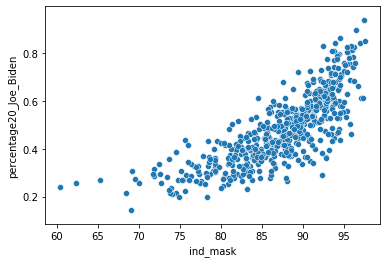

In [68]:
# sns.scatterplot(x=elec_geo_df['ind_mask'], y = elec_geo_df['percentage20_Joe_Biden'])
sns.scatterplot(x=non_impute['ind_mask'], y = non_impute['percentage20_Joe_Biden'])

In [ ]:
elec_geo_df.to_file('data/elec.geojson', driver='GeoJSON')
